In [1]:
## trello request: https://trello.com/c/fsJJHKuf/1484-email-unsubscriptions-20
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils_gen as u

plt.rcParams['figure.figsize'] = (12, 9)
pd.set_option('precision', 2)

/usr/local/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [24]:
conn = u.load_connection()

In [4]:
sql_email_status = '''
SELECT *
FROM cio.customer_event
WHERE timestamp >= '2018-11-04'
AND timestamp < '2019-02-24'
'''

df_subscription_status = pd.read_sql(sql_email_status, conn)

In [5]:
df_subscribers = df_subscription_status[df_subscription_status['event_type'] == 'customer_subscribed']
df_unsubscribers = df_subscription_status[df_subscription_status['event_type'] == 'customer_unsubscribed']

In [6]:
all_users_byweek = df_subscription_status.set_index('timestamp').groupby(pd.Grouper(freq='W')).agg(
    {'customer_id': lambda x: len(x.unique())})

In [7]:
unsubscribed_users_byweek = df_unsubscribers.set_index('timestamp').groupby(pd.Grouper(freq='W')).agg(
    {'customer_id': lambda x: len(x.unique())})

In [8]:
((unsubscribed_users_byweek / all_users_byweek) * 100).head()

,customer_id
timestamp,
2018-11-04,46.95
2018-11-11,46.39
2018-11-18,69.68
2018-11-25,58.30
2018-12-02,64.98


In [9]:
sql_email_event  = '''
SELECT *
FROM cio.email_sent
WHERE timestamp >= '{start_date}'
AND timestamp < '{end_date}'
'''

In [14]:
df_percentusers_emails = pd.DataFrame()
df_percentunsub_emails = pd.DataFrame()

In [15]:
## Week-to-week, what's the percentage of total email subscribers who are receiving 1, 2, 3, 4, 5, 6+ emails per week?
## What percentage of these users in each '# of emails received' category unsubscribed in that time period?

for group, df in df_subscription_status.set_index('timestamp').groupby(pd.Grouper(freq='W')):
    string_dict = {'start_date': group, 'end_date': group + pd.Timedelta(days=7)}
    
    ##  grab emails
    df_emails_sub = pd.read_sql(sql_email_event.format(**string_dict), conn)
    
    num_emails_peruser = df_emails_sub.groupby('customer_id')['email_id'].size().reset_index()
    num_emails_peruser['num_emails'] = pd.cut(
        num_emails_peruser['email_id'],
        bins=[0, 1, 2, 3, 4, 5, num_emails_peruser['email_id'].max()],
        labels=['1', '2', '3', '4', '5', '6+']
    )
    
    num_users_emails = num_emails_peruser.groupby('num_emails').agg({'customer_id': lambda x: len(x.unique())})
    percent_users = (num_users_emails / num_users_emails.sum())*100
    percent_users.rename(columns={'customer_id': group}, inplace=True)
    percent_users = percent_users.transpose()
    
    df_percentusers_emails = df_percentusers_emails.append(percent_users)
    
    
    ##  grab unsubscribed events
    unsubscribers = df[df['event_type'] == 'customer_unsubscribed']['customer_id'].unique()
    num_emails_peruser.loc[num_emails_peruser['customer_id'].isin(unsubscribers), 'unsubscriber'] = 1
    num_unsubscribers_emails = num_emails_peruser[num_emails_peruser['unsubscriber'] == 1].groupby('num_emails').agg(
        {'customer_id': lambda x: len(x.unique())}).fillna(0)
    percent_unsubscribe = (num_unsubscribers_emails / num_users_emails)*100
    percent_unsubscribe.rename(columns={'customer_id': group}, inplace=True)
    percent_unsubscribe = percent_unsubscribe.transpose()

    df_percentunsub_emails = df_percentunsub_emails.append(percent_unsubscribe)

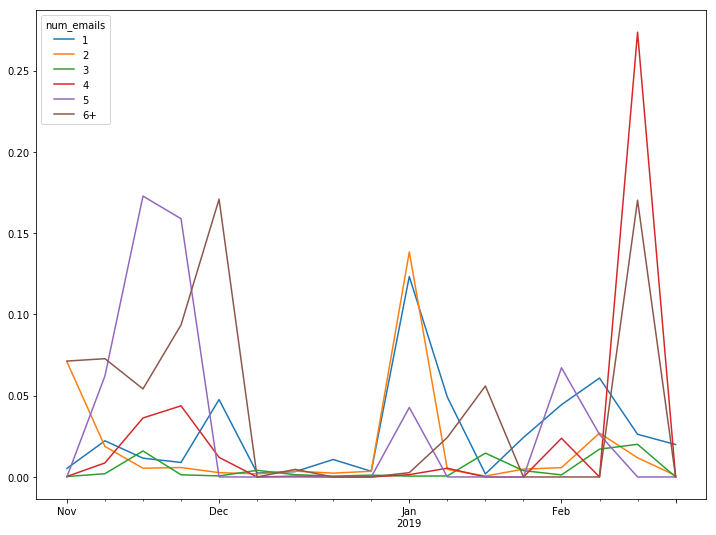

In [17]:
df_percentunsub_emails.plot()

In [18]:
df_percentusers_emails.to_csv('percentuser_emailed.csv')
df_percentunsub_emails.to_csv('percentunsub_emailed.csv')

In [10]:
sql_email_event  = '''
SELECT customer_id, count(DISTINCT email_id) as num_emails
FROM cio.email_sent
WHERE timestamp >= '{start_date}'
AND timestamp < '{end_date}'
GROUP BY customer_id
'''

sql_signups = '''
SELECT *
FROM signups
WHERE northstar_id in ({users})
AND created_at <= '{end_date}'
AND created_at >= ('{start_date}'::timestamp - INTERVAL '1 month')
'''

In [25]:
## What percentage of users receiving 4+ emails were signed up for 1 campaign? 2+ campaigns?
df_signups = pd.DataFrame()
for group, df in df_subscription_status.set_index('timestamp').groupby(pd.Grouper(freq='W')):
    string_dict = {'start_date': group, 'end_date': group + pd.Timedelta(days=7)}
    
    #  grab emails from that week
    df_emails_sub = pd.read_sql(sql_email_event.format(**string_dict), conn)
    df_emails_sub = df_emails_sub[df_emails_sub['num_emails'] >= 4]
    
    #  grab users 
    users = u.sql_stringify_list(df_emails_sub['customer_id'].unique())
    string_dict['users'] = users
    
    #  grab signups 
    df_signups_sub = pd.read_sql(sql_signups.format(**string_dict), conn)
    num_signups_peruser = df_signups_sub.groupby('northstar_id').size()

    percent_onesignup = (num_signups_peruser == 1).sum() / len(df_emails_sub['customer_id'].unique())
    percent_moresignups = (num_signups_peruser >= 2).sum() / len(df_emails_sub['customer_id'].unique())
    
    df_signups = df_signups.append({
        'Date': group,
        'Number of Users with 1 signup': (num_signups_peruser == 1).sum(),
        'Number of Users 2+ signups': (num_signups_peruser >= 2).sum(),
        'Percent of Users with 1 signup': percent_onesignup,
        'Percent of Users with 2+ signups': percent_moresignups,
    }, ignore_index=True)

In [26]:
df_signups

,Date,Number of Users 2+ signups,Number of Users with 1 signup,Percent of Users with 1 signup,Percent of Users with 2+ signups
0,2018-11-04,6085.0,31312.0,0.08,0.02
1,2018-11-11,5816.0,45474.0,0.30,0.04
2,2018-11-18,2068.0,2915.0,0.51,0.36
3,2018-11-25,5313.0,5781.0,0.19,0.18
4,2018-12-02,3759.0,5068.0,0.25,0.19
5,2018-12-09,1692.0,2090.0,0.24,0.20
6,2018-12-16,3944.0,9730.0,0.03,0.01
7,2018-12-23,540.0,1819.0,0.67,0.20
8,2018-12-30,799.0,1011.0,0.49,0.39
9,2019-01-06,3038.0,13050.0,0.11,0.03


In [27]:
df_signups.to_csv('signups_emails.csv')